## How do you make a program run faster?

We talked about _one_ way to do that—by caching (storing in advance) some data to be fetched so that we don't have to run a long calculation any time a client asks for it. 

But what if caching isn't enough?

**To answer this, we have to understand what's making a program take a long time in the first place.**

## Reason 1: Waiting around for things

This is called an IO-bound program: a program that spends a lot of its time waiting for user input, or waiting for an HTTP request to return a result, et cetera. You can think of this like the process of taking a flight or a long-distance train trip: you hurry to get to the station, then wait on the security line, then rush through security, then wait for boarding, then rush on the train/plane, then wait for it to get there...

It looks kind of like this:

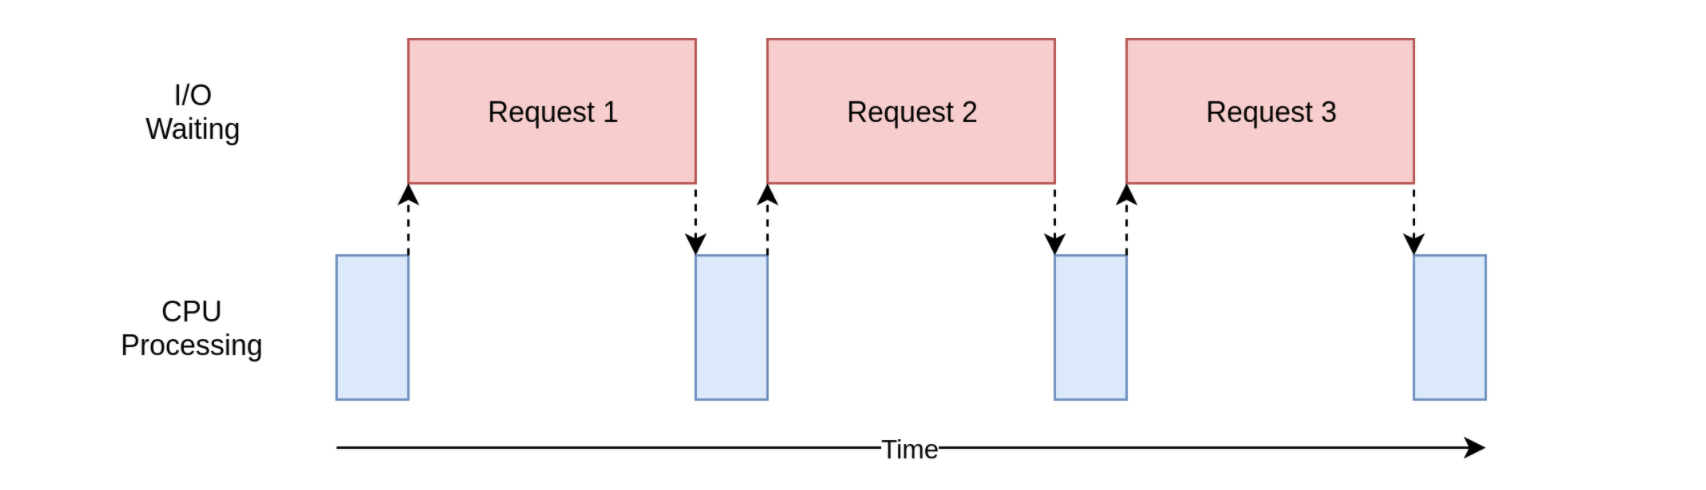

## Reason 2: Doing a lot of stuff

This is called a CPU-bound program: a program that spends a lot of time on _actual computation_ that just takes a long time. You can think of this like the process of phone banking: you receive a CSV with a bunch of names and phone numbers, and you have to call each of these people to encourage them to vote for a mayoral candidate. There's no waiting around: you have to steadily grind through the work.

It looks kind of like this:

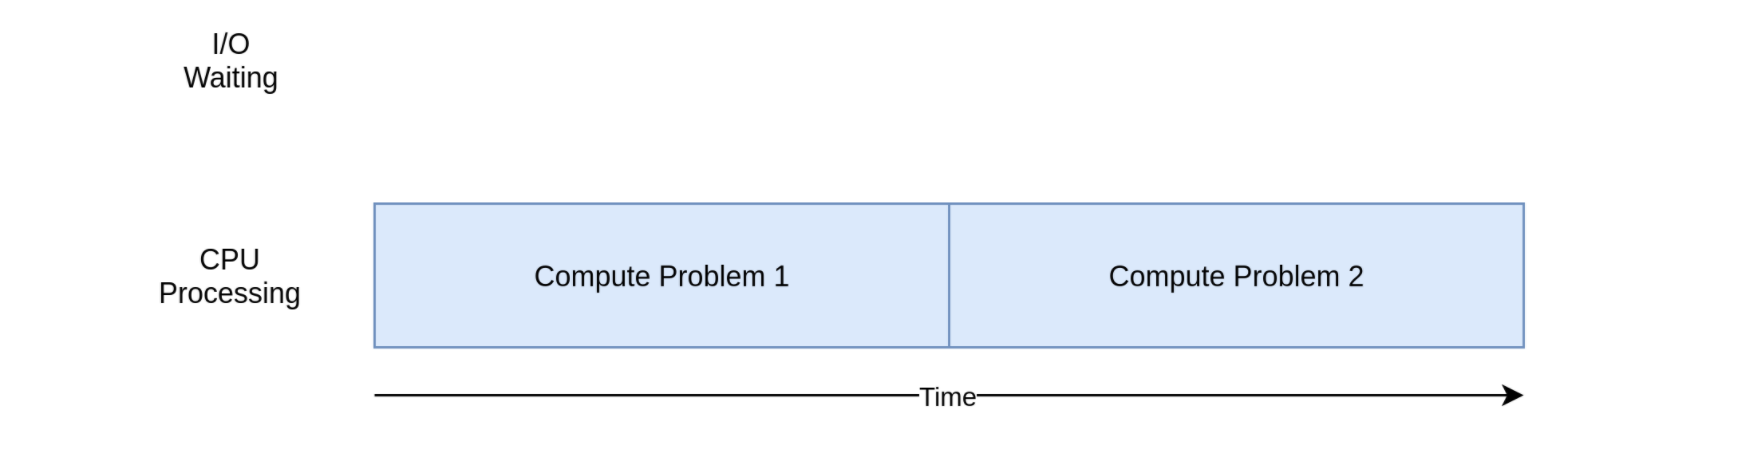

## Here's an example of an IO-bound program:

In [ ]:
import sys
!{sys.executable} -m pip install requests
!{sys.executable} -m pip install aiohttp

import requests
import time

In [ ]:
def download_site(url, session):
    with session.get(url) as response:
        print(f"Read {len(response.content)} from {url}")


def download_all_sites(sites):
    with requests.Session() as session:
        for url in sites:
            download_site(url, session)


if __name__ == "__main__":
    sites = [
        "https://www.jython.org",
        "http://olympus.realpython.org/dice",
    ] * 80
    start_time = time.time()
    download_all_sites(sites)
    duration = time.time() - start_time
    print(f"Downloaded {len(sites)} in {duration} seconds")

## One way to make it faster: Threads

In [ ]:
import concurrent.futures
import requests
import threading
import time

thread_local = threading.local()

def get_session():
    if not hasattr(thread_local, "session"):
        thread_local.session = requests.Session()
    return thread_local.session


def download_site(url):
    session = get_session()
    with session.get(url) as response:
        print(f"Read {len(response.content)} from {url}")


def download_all_sites(sites):
    with concurrent.futures.ThreadPoolExecutor(max_workers=5) as executor:
        executor.map(download_site, sites)


if __name__ == "__main__":
    sites = [
        "https://www.jython.org",
        "http://olympus.realpython.org/dice",
    ] * 80
    start_time = time.time()
    download_all_sites(sites)
    duration = time.time() - start_time
    print(f"Downloaded {len(sites)} in {duration} seconds")

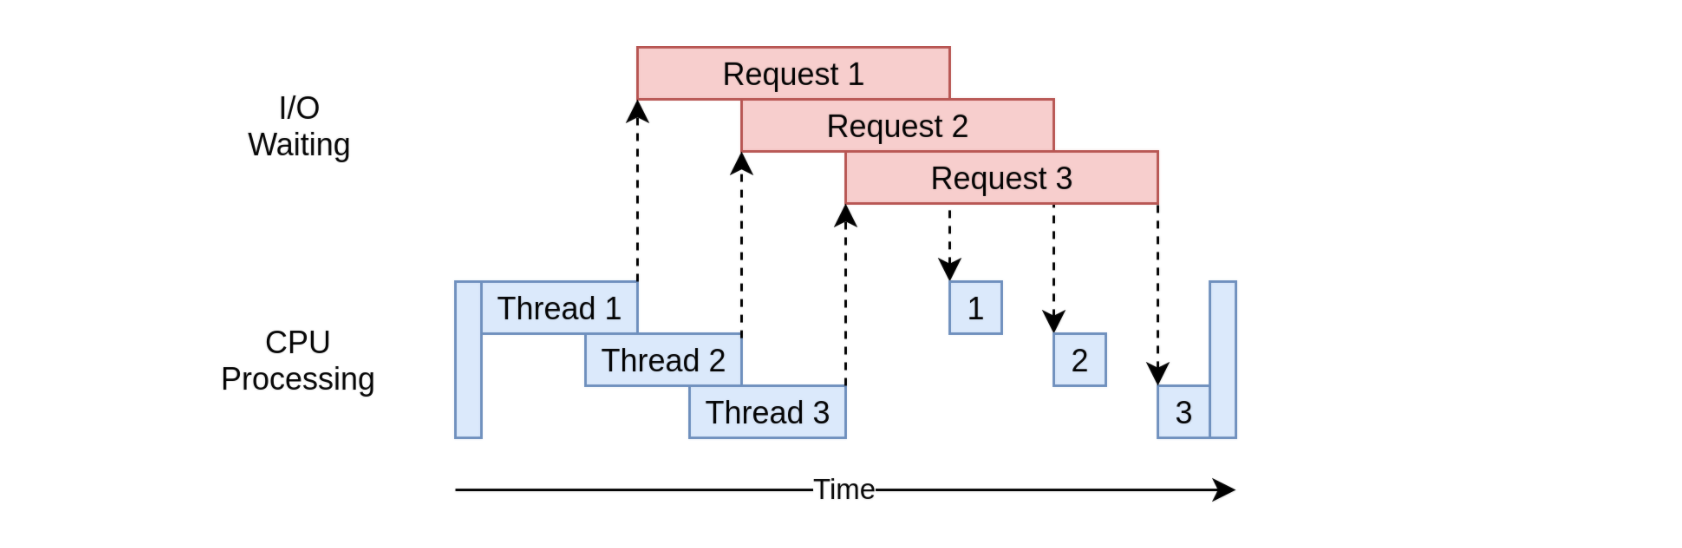

## Another way to make it faster: Concurrency

In [ ]:
import asyncio
import time
import aiohttp

async def download_site(session, url):
    async with session.get(url) as response:
        print("Read {0} from {1}".format(response.content_length, url))

async def download_all_sites(sites):
    async with aiohttp.ClientSession() as session:
        tasks = []
        for url in sites:
            task = asyncio.ensure_future(download_site(session, url))
            tasks.append(task)
        await asyncio.gather(*tasks, return_exceptions=True)

if __name__ == "__main__":
    sites = [
        "https://www.jython.org",
        "http://olympus.realpython.org/dice",
    ] * 80
    start_time = time.time()
    await download_all_sites(sites) #in not-a-jupyter-notebook this is asyncio.run(download_all_sites(sites))
    duration = time.time() - start_time
    print(f"Downloaded {len(sites)} sites in {duration} seconds")

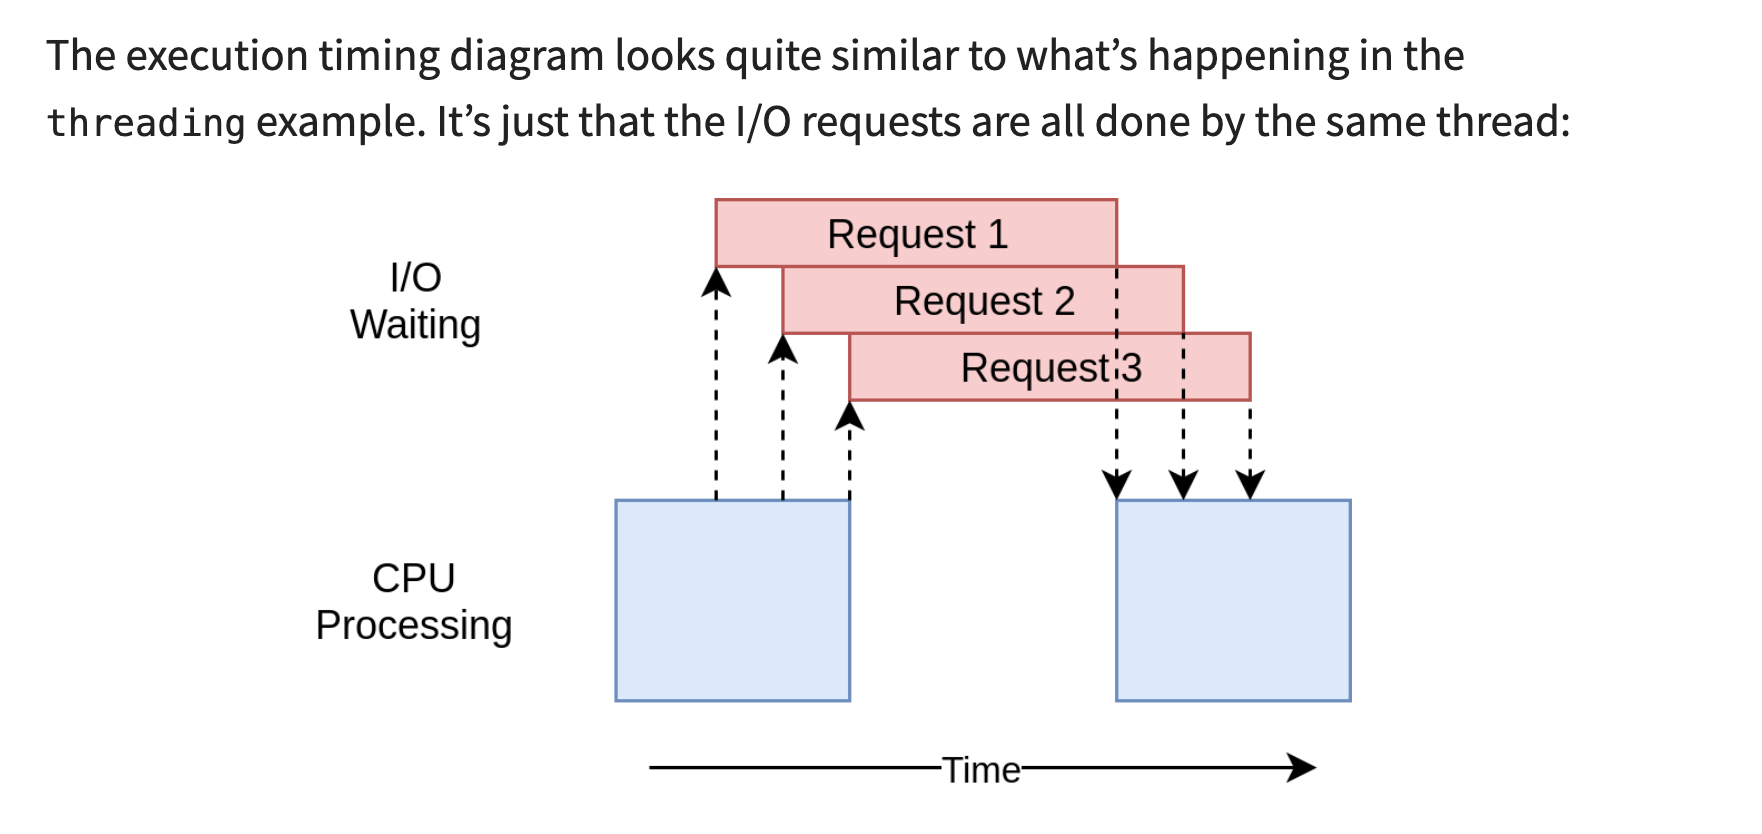

In [ ]:
import time

ready = []
waiting = []
        
def slow_query_called(name, up_to=10):
    for i in range(up_to):
        time.sleep(0.5) # This represents the code waiting for something to happen
        print(f" {name} yielded {i}")
        yield i
        
ready.append(slow_query_called("Bob"))
ready.append(slow_query_called("Doug"))      

In [ ]:
while ready or waiting:
    if ready:
        readiest = ready.pop(0)
        try:
            next(readiest)
            waiting.append(readiest)
        except StopIteration:
            print(f"completed")
    else:
        waitingest = waiting.pop(0)
        ready.append(waitingest)

## For CPU-bound programs, multiprocessing can help.

In [ ]:
import requests
import multiprocessing
import time

session = None


def set_global_session():
    global session
    if not session:
        session = requests.Session()


def download_site(url):
    with session.get(url) as response:
        name = multiprocessing.current_process().name
        print(f"{name}:Read {len(response.content)} from {url}")


def download_all_sites(sites):
    with multiprocessing.Pool(initializer=set_global_session) as pool:
        pool.map(download_site, sites)


if __name__ == "__main__":
    sites = [
        "https://www.jython.org",
        "http://olympus.realpython.org/dice",
    ] * 80
    start_time = time.time()
    download_all_sites(sites)
    duration = time.time() - start_time
    print(f"Downloaded {len(sites)} in {duration} seconds")


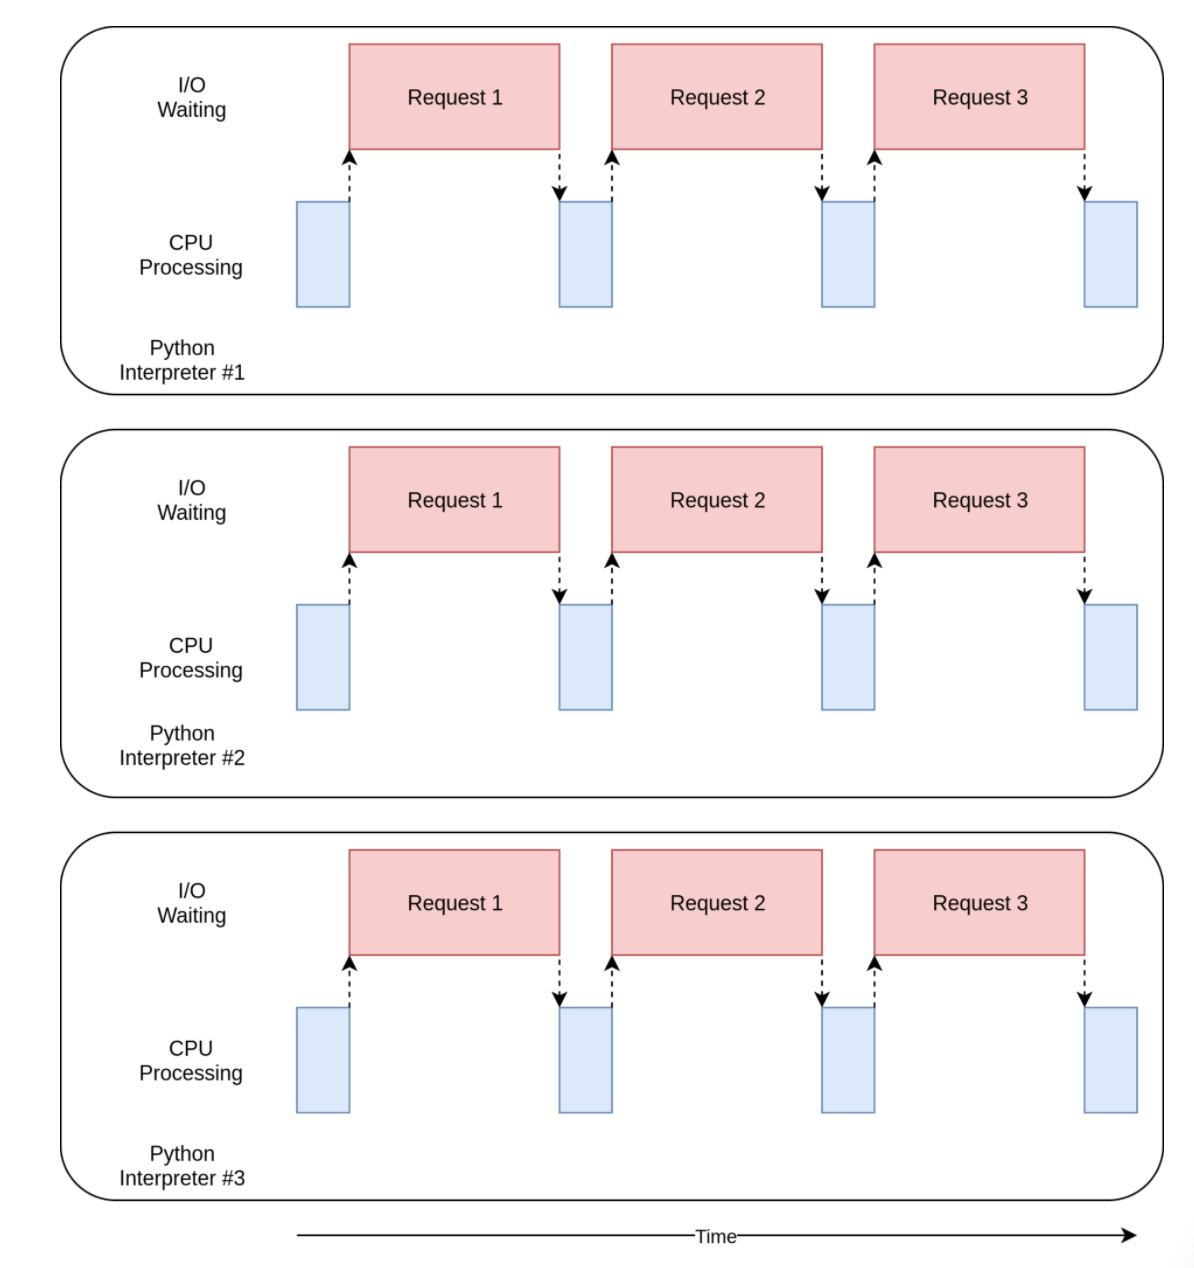

[Images from Here](https://realpython.com/python-concurrency/)